In [1]:
use_saved_model = False
saved_model_name = "my_model"
percent_training_data = 0.1  # 1 = 100% of data, 0.5 = 50% of data, etc.

In [3]:

# Install kaggle and dataset, extract data
"""%matplotlib inline
%pip install kaggle
%pip install pydot
%pip install kaggle
%pip install handcalcs
%pip install tensorflow-metal
!brew install graphviz
!/Users/jon/Library/Python/3.9/bin/kaggle competitions download -c sf-crime
import shutil
shutil.unpack_archive("sf-crime.zip", "sf-crime")
shutil.unpack_archive("sf-crime/train.csv.zip", "sf-crime/train")
shutil.unpack_archive("sf-crime/test.csv.zip", "sf-crime/test")
shutil.unpack_archive("sf-crime/sampleSubmission.csv.zip", "sf-crime/sampleSubmission")
"""

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 886.8 kB/s eta 0:00:0031m1.7 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 1.1 MB/s eta 0:00:001.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packag

In [4]:

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import keras
from keras.models import Sequential, Model
from keras.layers import UpSampling2D, Add, Concatenate, Input, BatchNormalization, Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation, RandomZoom
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split

import re
import random
import handcalcs.render

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:

%%render
a = -3
b = 2

<IPython.core.display.Latex object>

In [4]:
# load csv data from train.csv
train = pd.read_csv("sf-crime/train/train.csv")
train.sample(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
860936,2003-03-22 20:48:00,OTHER OFFENSES,RESISTING ARREST,Saturday,MISSION,JUVENILE CITED,25TH ST / YORK ST,-122.408041,37.751257
860423,2003-03-31 11:00:00,DRUG/NARCOTIC,POSSESSION OF CONTROLLED SUBSTANCE,Monday,MISSION,"ARREST, BOOKED",21ST ST / SOUTH VAN NESS AV,-122.416721,37.757168
548759,2007-08-12 14:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Sunday,INGLESIDE,NONE,900 Block of CAYUGA AV,-122.439628,37.722412
453182,2008-12-24 15:00:00,FRAUD,"CREDIT CARD, THEFT BY USE OF",Wednesday,SOUTHERN,NONE,MARKET ST / 3RD ST,-122.403434,37.787643
532220,2007-11-04 05:06:00,PROSTITUTION,SOLICITS FOR ACT OF PROSTITUTION,Sunday,TENDERLOIN,"ARREST, CITED",ELLIS ST / LARKIN ST,-122.417710,37.784236


In [5]:
# load csv data from test.csv
test_useless = pd.read_csv("sf-crime/test/test.csv")
test_useless.sample(5)
test_useless["Address"].sample(10)

604036        1000 Block of TREAT AV
737893         0 Block of ADMIRAL AV
375862           BUSH ST / LARKIN ST
83799           24TH ST / POTRERO AV
177750        700 Block of MARKET ST
159364        2200 Block of HAYES ST
58934       1800 Block of NEWHALL ST
325078        200 Block of LARKIN ST
737663    300 Block of EUCALYPTUS DR
526146         3200 Block of 20TH AV
Name: Address, dtype: object

In [6]:
# convert the category column to a one hot encoded array
y_train = pd.get_dummies(train["Category"])
class_names = y_train.columns
x_train = train.drop(["Category", "Descript", "Resolution"], axis=1)
x_train

,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,Monday,TARAVAL,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,Monday,INGLESIDE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,Monday,SOUTHERN,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,Monday,SOUTHERN,TOWNSEND ST / 2ND ST,-122.390531,37.780607


In [7]:
def string_to_int(string):
    return sum([ord(c) for c in string])

# a function that takes an array of unique values and returns a dictionary with values as keys and indices as values
def get_dict(array):
    return {array[i]: i+1 for i in range(len(array))}

def min_max_normalize(array, min=None, max=None):
    if min is None: min = array.min()
    if max is None: max = array.max()
    return (array - min) / (max - min)

def address_get_dummies(data: pd.DataFrame, prefix=None):
    # create a new dataframe
    df = pd.DataFrame()

    # get all the street types
    types = []
    for address in data:
        # get all two chars that are capitalized with regex
        types += [prefix + "_" + match for match in re.findall(r"\b[A-Z]{2}\b", address)]
    types = list(set(types))

    # create a column for each street type
    # and set it to 1 if the address contains that street type
    for street_type in types:
        df[street_type] = data.apply(lambda x: 1.0 if street_type in x else 0.0)

    return df

def preprocess_data(df):
    """
    Preprocesses the data by converting strings to integers without normalization
    """
    # convert date to datetime
    df["Dates"] = pd.to_datetime(df["Dates"], format="%Y-%m-%d %H:%M:%S")
    # add new columns
    df["Year"] = df["Dates"].dt.year
    df["Month"] = df["Dates"].dt.month
    df["Day"] = df["Dates"].dt.day
    df["Hour"] = df["Dates"].dt.hour
    df["Minute"] = df["Dates"].dt.minute
    df["DayOfWeek"] = df["Dates"].dt.dayofweek
    df["WeekOfYear"] = df["Dates"].dt.isocalendar().week
    df = df.drop(["Dates"], axis=1)
    # convert pd district to one-hot encoding
    df = pd.concat([df, pd.get_dummies(df["PdDistrict"], prefix="PdDistrict", dtype=np.float32)], axis=1)
    df = df.drop(["PdDistrict"], axis=1)
    # convert addresses to one-hot encoding
    df = pd.concat([df, address_get_dummies(df["Address"], prefix="Address")], axis=1)
    df = df.drop(["Address"], axis=1)

    return df

def normalize_data(df):
    """
    Normalizes the data
    """
    df = df.copy()

    df["DayOfWeek"] = min_max_normalize(df["DayOfWeek"])
    df["Year"] = min_max_normalize(df["Year"])
    df["Month"] = min_max_normalize(df["Month"])
    df["Day"] = min_max_normalize(df["Day"])
    df["Hour"] = min_max_normalize(df["Hour"], 0, 23)
    df["Minute"] = min_max_normalize(df["Minute"], min=0, max=59)
    df["WeekOfYear"] = min_max_normalize(df["WeekOfYear"])
    
    # map the coordinates to a number by using min max normalization
    df["X"] = min_max_normalize(train["X"], -180, 180)
    df["Y"] = min_max_normalize(train["Y"], -90, 90)

    return df

def convert_df_to_numpy(df):
    """
    Converts the pandas dataframe to a numpy array
    """
    return np.asarray(df).astype(np.float32)

def split_data(x, y, test_size=0.2, np=False):
    """
    Splits the data into a training and validation set
    """
    # split the data into a training and validation set
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_size, random_state=42)
    # convert the dataframes to numpy arrays
    if np:
        x_train = convert_df_to_numpy(x_train)
        x_val = convert_df_to_numpy(x_val)
        y_train = convert_df_to_numpy(y_train)
        y_val = convert_df_to_numpy(y_val)
    return x_train, x_val, y_train, y_val

x_train: pd.DataFrame = preprocess_data(x_train)
#x_train: pd.DataFrame = normalize_data(x_train)

# take only x % of the training data with random sampling
x_train = x_train.sample(int(len(x_train) * percent_training_data))
y_train = y_train.loc[x_train.index]


# split the data into time and location data
# easier to get time of data and drop columns
x_train_time: pd.DataFrame = x_train[['DayOfWeek', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'WeekOfYear']]
# x_train_location is the rest of the data
x_train_location: pd.DataFrame = x_train.drop(columns=['DayOfWeek', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'WeekOfYear'], axis=1)

# put the time and location data back together
x_train_: pd.DataFrame = pd.concat([x_train_time, x_train_location], axis=1)

x_train, x_val, y_train, y_val = split_data(x_train_, y_train, np=True)

x_train_.sample(20)


,DayOfWeek,Year,Month,Day,Hour,Minute,WeekOfYear,X,Y,PdDistrict_BAYVIEW,...,Address_LN,Address_TR,Address_LA,Address_BL,Address_WK,Address_RW,Address_AL,Address_CR,Address_SF,Address_HY
812851,3,2003,11,13,11,15,46,-122.468977,37.715194,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451003,2,2009,1,7,8,10,2,-122.416047,37.783982,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
534512,0,2007,10,29,18,0,44,-122.417757,37.769814,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
429848,6,2009,4,19,23,55,16,-122.447744,37.728224,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
655179,3,2006,1,26,17,30,4,-122.392773,37.777087,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
487705,6,2008,6,29,3,40,26,-122.428950,37.767503,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121012,2,2013,10,2,12,0,40,-122.426383,37.776705,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39990,3,2014,10,30,18,1,44,-122.432006,37.721238,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120718,2,2013,10,2,22,30,40,-122.414030,37.782329,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346142,2,2010,7,28,14,26,30,-122.393119,37.740903,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2022-12-17 14:15:42.312056: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-17 14:15:42.312609: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



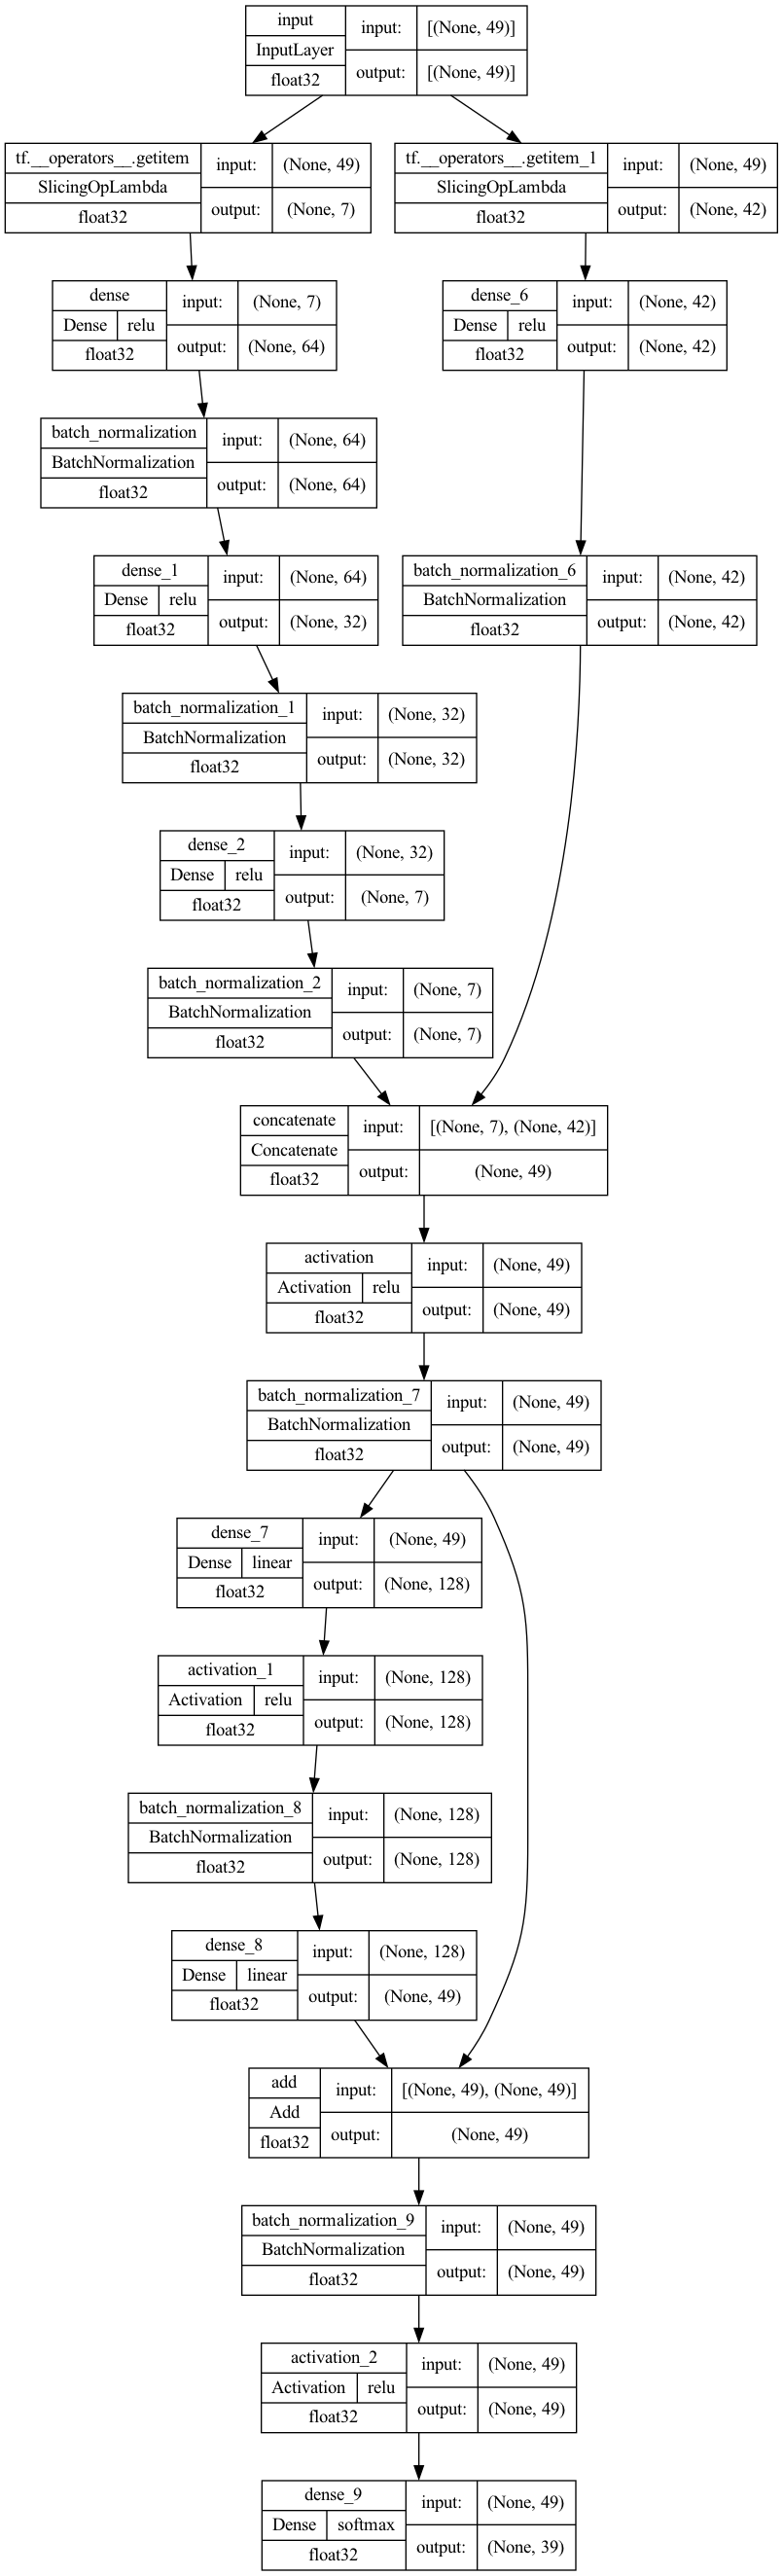

In [8]:
def plot_learning_curves(history):
    n = len(history.history['loss'])
    plt.plot(np.arange(1, n+1), history.history['loss'], label="training loss")
    plt.plot(np.arange(1, n+1), history.history['val_loss'], label="validation loss")
    plt.legend()
    plt.grid()
    plt.xticks(np.arange(1, n+1, 2))


def DenseReluBatchNorm(units: int, activation: str = "relu", use_bias: bool = True):
    return keras.Sequential(
        [
            Dense(units, use_bias=use_bias),
            Activation(activation),
            BatchNormalization(),
        ]
    )

def residual_block_shortcut(x, units, activation='relu', kernel_initializer='he_normal'):
    x_shortcut = x # Store the initial value of X in a variable
    # Perform convolution + batch norm operations on X
    x = Dense(units=units, kernel_initializer=kernel_initializer)(x)
    x = Activation(activation)(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.2)(x)
    x = Dense(units=x_shortcut.shape[1], kernel_initializer=kernel_initializer)(x)
    assert x.shape == x_shortcut.shape  # needs to be the same shape to add
    x = Add()([x, x_shortcut]) # SKIP Connection
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def residual_block_parallel(x, activation='relu', kernel_initializer='he_normal'):
     # Store the initial value of X in a variable
    x_input_time_data = x[:, :7]
    x_input_loc_data = x[:, 7:]

    # time data res block
    x_t = Dense(units=64, kernel_initializer=kernel_initializer, activation=activation)(x_input_time_data)
    x_t = BatchNormalization()(x_t)
    
    x_t = Dense(units=32, kernel_initializer=kernel_initializer, activation=activation)(x_t)
    x_t = BatchNormalization()(x_t)
    
    x_t = Dense(units=x_input_time_data.shape[1], kernel_initializer=kernel_initializer, activation=activation)(x_t)
    x_t = BatchNormalization()(x_t)
    
    
    # location data res block
    x_d = Dense(units=128, kernel_initializer=kernel_initializer, activation=activation)(x_input_loc_data)
    x_d = BatchNormalization()(x_d)
    
    x_d = Dense(units=64, kernel_initializer=kernel_initializer, activation=activation)(x_input_loc_data)
    x_d = BatchNormalization()(x_d)

    x_d = Dense(units=32, kernel_initializer=kernel_initializer, activation=activation)(x_input_loc_data)
    x_d = BatchNormalization()(x_d)

    x_d = Dense(units=x_input_loc_data.shape[1], kernel_initializer=kernel_initializer, activation=activation)(x_input_loc_data)
    x_d = BatchNormalization()(x_d)

    # concat time and location data
    x = Concatenate()([x_t, x_d])
    x = Activation(activation)(x)
    x = BatchNormalization()(x)
    return x

def build_model():
    input_shape = x_train.shape[1]
    output_shape = y_train.shape[1]

    input_tensor = Input(shape=(input_shape,), name='input')

    x = residual_block_parallel(x=input_tensor)
    x = residual_block_shortcut(x=x, units=128)

    output_tensor = Dense(units=y_train.shape[1], activation='softmax')(x)  # we need to classify the category of the crime
    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = build_model()

tf.keras.utils.plot_model(model, to_file="/tmp/model.png", show_layer_activations=True, show_shapes=True, show_dtype=True, show_layer_names=True)


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 49)]         0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 7)           0           ['input[0][0]']                  
 ingOpLambda)                                                                                     
                                                                                                  
 dense (Dense)                  (None, 64)           512         ['tf.__operators__.getitem[0][0]'
                                                                 ]                                
                                                                                              

In [11]:
# against Vanishing/Exploding Gradients
optimizer = Adam(learning_rate=0.005, clipnorm=1.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=7,
)

if use_saved_model:
    model = tf.keras.models.load_model(f'./{saved_model_name}')

history = model.fit(
  x_train,
  y_train,
  epochs=1,
  batch_size=32,
  validation_split=.1,
  callbacks=[early_stopping],
  verbose=1,
)

2022-12-17 14:17:14.699780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1976/1976 [==============================] - ETA: 0s - loss: 2.5736 - accuracy: 0.2356

2022-12-17 14:18:35.216434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1976/1976 [==============================] - 84s 41ms/step - loss: 2.5736 - accuracy: 0.2356 - val_loss: 3.2208 - val_accuracy: 0.1443


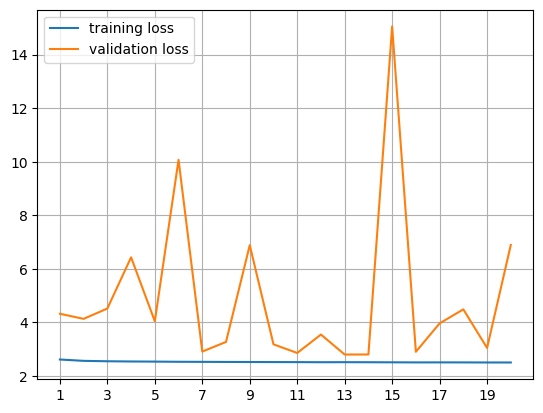

In [ ]:
plot_learning_curves(history)

In [12]:
from sklearn.metrics import classification_report

predicted_class_probabilities = model.predict(x_val)
predicted_labels = np.argmax(predicted_class_probabilities, axis=1)

# convert predicated_labels to one-hot encoding
predicted_labels = keras.utils.to_categorical(predicted_labels, num_classes=predicted_class_probabilities.shape[1])

print(classification_report(y_true=y_val, y_pred=predicted_labels, target_names=class_names))


2022-12-17 14:18:44.327996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


549/549 [==============================] - 3s 6ms/step
                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00        32
                    ASSAULT       0.00      0.00      0.00      1513
                 BAD CHECKS       0.00      0.00      0.00         9
                    BRIBERY       0.00      0.00      0.00         6
                   BURGLARY       0.00      0.00      0.00       705
         DISORDERLY CONDUCT       0.00      0.00      0.00        85
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00        52
              DRUG/NARCOTIC       0.00      0.00      0.00      1074
                DRUNKENNESS       0.00      0.00      0.00        78
               EMBEZZLEMENT       0.00      0.00      0.00        21
                  EXTORTION       0.00      0.00      0.00         8
            FAMILY OFFENSES       0.00      0.00      0.00         6
     FORGERY/COUNTERFEITING       0.00      0.0

/Users/jon/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jon/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_val.argmax(axis=1), predicted_labels.argmax(axis=1)), annot=True, fmt='d', cmap='magma').set(
    xlabel="Actual classes", ylabel="Predicted classes", title='Confusion matrix')
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [175610, 17561]

In [24]:
model.save(saved_model_name, save_format='tf')

INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
from sklearn.metrics import classification_report

predicted_class_probabilities = model.predict(test_useless)
predicted_labels = np.argmax(predicted_class_probabilities, axis=1)

# convert predicated_labels to one-hot encoding
predicted_labels = keras.utils.to_categorical(predicted_labels, num_classes=predicted_class_probabilities.shape[1])

print(classification_report(y_true=y_val, y_pred=predicted_labels, target_names=class_names))
